# Знайомство з даними

In [1]:
!gdown --id 1AEZJUW-JCbBn9oIRnyL2jYmJrGPHJZRj

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AEZJUW-JCbBn9oIRnyL2jYmJrGPHJZRj
To: /content/order_reviews.csv
100% 14.4M/14.4M [00:00<00:00, 15.5MB/s]


In [2]:
!gdown --id 11V5_01mPWjYV0x2drDdNF4oCNigOZMmG

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11V5_01mPWjYV0x2drDdNF4oCNigOZMmG
To: /content/order_payments.csv
100% 5.78M/5.78M [00:00<00:00, 24.6MB/s]


In [4]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
import string
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import seaborn as sns
import xgboost as xgb
import plotly.express as px


Читаємо файли з відгуками та сумами замовлень

In [5]:
reviews = pd.read_csv('/content/order_reviews.csv')
payments = pd.read_csv('/content/order_payments.csv')

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


Присутні відгуки без тексту, відразу їх відкидаємо

In [7]:
reviews = reviews.dropna(subset='review_comment_message')

Перевіряємо платежі на дуплікати id

In [8]:
payments[payments.duplicated(subset='order_id', keep = False)].sort_values(by='order_id')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
20036,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44.11
98894,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
30155,0071ee2429bc1efdc43aa3e073a5290e,2,voucher,1,92.44
...,...,...,...,...,...
21648,ffa1dd97810de91a03abd7bd76d2fed1,2,voucher,1,418.73
32912,ffa39020fe7c8a3e907320e1bec4b985,1,credit_card,1,7.13
3009,ffa39020fe7c8a3e907320e1bec4b985,2,voucher,1,64.01
75188,ffc730a0615d28ec19f9cad02cb41442,1,credit_card,1,14.76


З'єднуємо інформацію про сплату з таблицею відгуків

In [9]:
payments_sum = pd.DataFrame(payments.groupby('order_id')['payment_value'].agg('sum'))
reviews = reviews.merge(payments_sum.payment_value, on = 'order_id', how='inner').copy()

In [10]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41752 entries, 0 to 41751
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   review_id                41752 non-null  object 
 1   order_id                 41752 non-null  object 
 2   review_score             41752 non-null  int64  
 3   review_comment_title     9986 non-null   object 
 4   review_comment_message   41752 non-null  object 
 5   review_creation_date     41752 non-null  object 
 6   review_answer_timestamp  41752 non-null  object 
 7   payment_value            41752 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 2.5+ MB


In [11]:
reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_value
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,222.84
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,1333.25
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,613.25
3,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,42.78
4,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,103.06
5,9314d6f9799f5bfba510cc7bcd468c01,0dacf04c5ad59fd5a0cc1faa07c34e39,2,NaN,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",2018-01-18 00:00:00,2018-01-20 21:25:45,188.65
6,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,99.28
7,d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,5,Ótimo,Loja nota 10,2018-07-10 00:00:00,2018-07-11 14:10:25,65.24
8,0e0190b9db53b689b285d3f3916f8441,79832b7cb59ac6f887088ffd686e1d5e,5,NaN,obrigado pela atençao amim dispensada,2017-12-01 00:00:00,2017-12-09 22:58:58,79.56
9,fe3db7c069d694bab50cc43463f91608,2ca73e2ff9e3a186ad1e1ffb9b1d9c10,5,NaN,A compra foi realizada facilmente.\r\nA entreg...,2018-03-23 00:00:00,2018-04-01 00:27:51,179.87


# Аналіз сплат за замовлення

In [12]:
reviews.describe()

,review_score,payment_value
count,41752.000000,41752.000000
mean,3.640472,172.448021
std,1.626351,244.014729
min,1.000000,0.000000
25%,2.000000,64.880000
50%,4.000000,110.765000
75%,5.000000,187.530000
max,5.000000,13664.080000


Бачимо великі викиди. Порахуємо відсоток викидів від усіх сплат

In [13]:
px.histogram(reviews, x='payment_value', marginal='box', title='Розподіл сум замовлень')


In [14]:
Q1 = reviews['payment_value'].quantile(0.25)
Q3 = reviews['payment_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [15]:
np.mean((reviews['payment_value'] < lower_bound) | (reviews['payment_value'] > upper_bound))

0.08143322475570032

Викиди ставлять лише 8 відцотків від усіх даних. Очистимо дані від них

In [16]:
reviews = reviews[(reviews['payment_value'] >= lower_bound) & (reviews['payment_value'] <= upper_bound)]

In [17]:
reviews.describe()

,review_score,payment_value
count,38352.000000,38352.000000
mean,3.666693,121.288182
std,1.613791,76.826753
min,1.000000,0.000000
25%,2.000000,62.050000
50%,4.000000,102.030000
75%,5.000000,163.165000
max,5.000000,371.420000


In [18]:
px.histogram(reviews, x='payment_value', marginal='box', title='Розподіл сум замовлень(без викидiв)')


# Транформація текстових даних

In [19]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')
stop_words = set(stopwords.words('portuguese'))
stemmer = RSLPStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


Функція преведення тексту до нижнього регістру, видалення усіх непотрібних символів, стоп слів. Подальша токенізація та стеммінг.

In [20]:
def preprocess_text(text):

    text = text.lower()

    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))

    text = re.sub(r'[^a-zA-ZáéíóúãõçÁÉÍÓÚÃÕÇ\s]', '', text)

    tokens = word_tokenize(text)

    tokens = [stemmer.stem(word) for word in tokens if word.strip() and word.lower() not in stop_words]

    return ' '.join(tokens)


In [21]:
reviews['processed_review_comment_message'] = reviews['review_comment_message'].apply(preprocess_text)

Оброблені відгуки

In [22]:
reviews['processed_review_comment_message'].head(10)

0                            receb bem ant praz estipul
3                           pouc travandopel val ta boa
4                  vend confi produt ok entreg ant praz
5              gost sab sempr receb compr agor decpcion
6                                                  péss
7                                               loj not
8                             obrig atença amim dispens
9     compr realiz facil entreg efetu ant praz dad p...
10                                   relógi bonit barat
11                                  gost compr gat lebr
Name: processed_review_comment_message, dtype: object

Найпопулярніші слова у відгуках

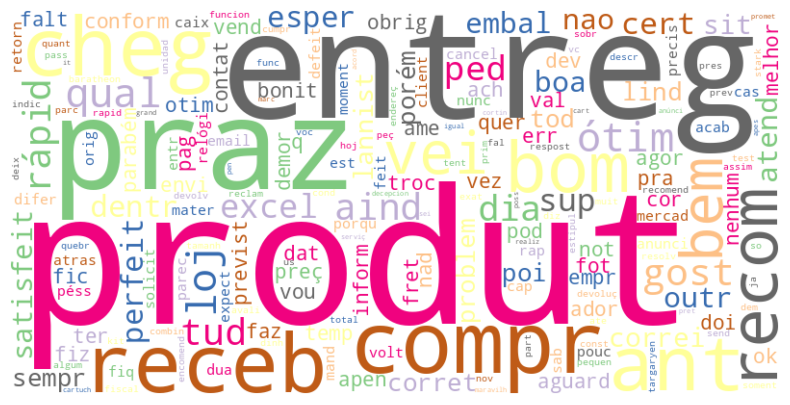

In [23]:
all_reviews = ' '.join(reviews['processed_review_comment_message'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap = 'Accent').generate_from_frequencies(Counter(word_tokenize(all_reviews)))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Розмітка класів

Промітимо відгуки за значенням оцінки товару(1,2 як негативний, 3,4,5 як позитивний)

In [24]:
reviews['positivity_score'] = reviews['review_score'].map({1:0 , 2:0, 3:1, 4:1, 5:1})

Найпопулярніші слова у позитивних відгуках

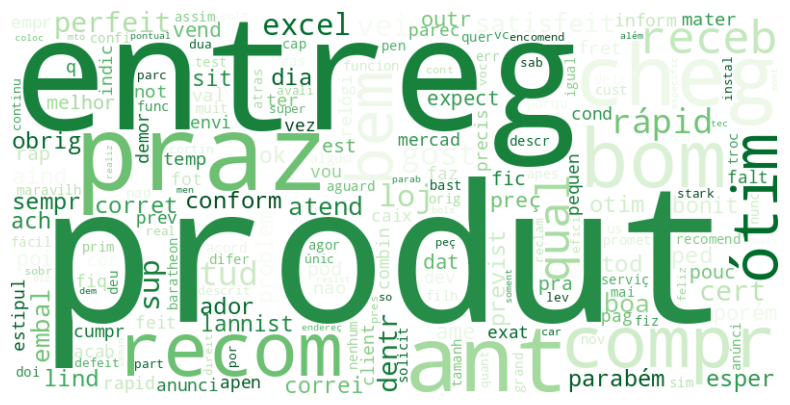

In [25]:
all_pos_reviews = ' '.join(reviews[reviews['positivity_score'] == 1].processed_review_comment_message)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap = 'Greens').generate_from_frequencies(Counter(word_tokenize(all_pos_reviews)))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Найпопулярніші слова у негативних відгуках

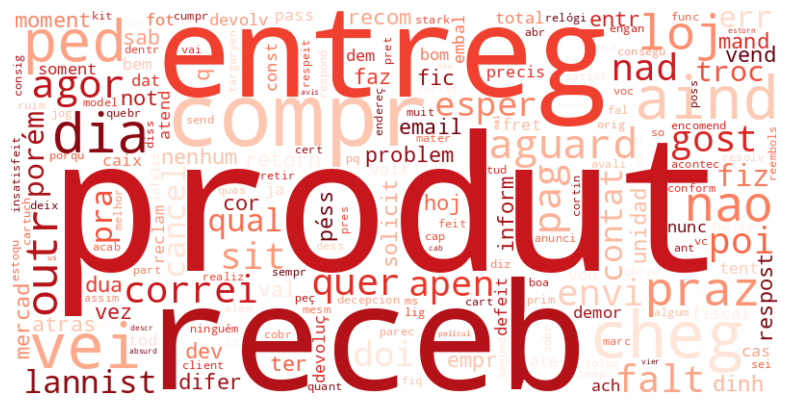

In [26]:
all_neg_reviews = ' '.join(reviews[reviews['positivity_score'] == 0].processed_review_comment_message)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap = 'Reds').generate_from_frequencies(Counter(word_tokenize(all_neg_reviews)))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Ділимо дані на тренувальні та тестові

In [27]:
X_train, X_test, y_train, y_test = train_test_split\
(reviews.processed_review_comment_message, reviews[['positivity_score','payment_value']],\
 test_size=0.2, random_state=123, stratify=reviews.positivity_score)

Тансформуємо текст у tf idf вектори

In [28]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Побудова та оцінка класифікатора

Вводимо класифікатор, навчаємо його та робимо передбачення на тестовій виборці.
Відображаємо метрики якості моделі.

In [29]:
logreg = LogisticRegression(random_state=123)
logreg.fit(X_train_tfidf, y_train['positivity_score'])
y_pred = logreg.predict(X_test_tfidf)

print(classification_report(y_test['positivity_score'], y_pred))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      2039
           1       0.92      0.93      0.92      5632

    accuracy                           0.89      7671
   macro avg       0.86      0.85      0.85      7671
weighted avg       0.88      0.89      0.88      7671



Добавимо у класифікатор третій класс відповідаючий до нейтрального коментаря. Коментар буде помічатися нейтральним якщо ймовірність надлежати до першого класу знаходится на відрізку [0.3 ; 0.7]. Негативний та позитивний відповідно нижче та вище за ці границі.

In [30]:
prob = logreg.predict_proba(X_test_tfidf)
prob_pred = [0 if i < 0.3 else 2 if 0.3 <= i <= 0.7 else 1 for i in prob[:,1]]
test = pd.DataFrame({'pred': prob_pred, 'true': y_test['positivity_score']})
test2 = test[test['pred'] != 2]
print(classification_report(test2.pred, test2.true))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1296
           1       0.96      0.96      0.96      5056

    accuracy                           0.94      6352
   macro avg       0.91      0.91      0.91      6352
weighted avg       0.94      0.94      0.94      6352



In [32]:
reviews['pred'] = test['pred']

Графічна оцінка класифікатора

Text(0.5, 1.0, 'Розподіл оцінок для нейтральних коментарів')

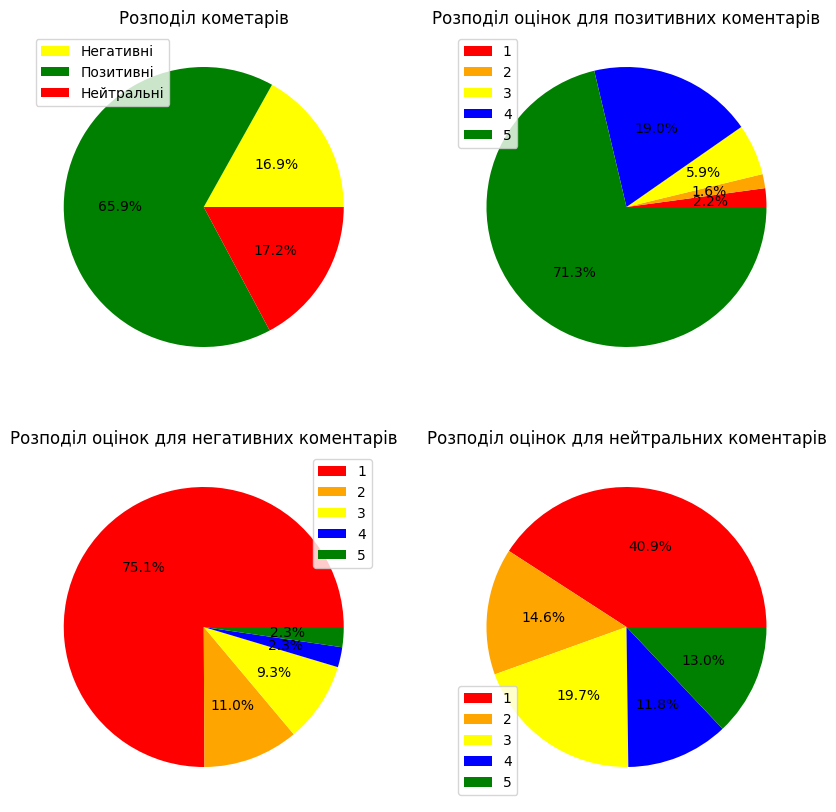

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

data = reviews.groupby('pred')['pred'].count()
axes[0,0].pie(data, autopct='%1.1f%%',colors = ['yellow','green','red'])
axes[0,0].legend(data.index.map({0:'Негативні',1:'Позитивні',2:'Нейтральні'}))
axes[0,0].set_title('Розподіл кометарів')

colors = ['green','blue','yellow','orange','red']

data = reviews[reviews['pred'] == 1].groupby('review_score')['review_score'].count()
axes[0,1].pie(data, autopct='%1.1f%%',colors=colors[::-1])
axes[0,1].legend(data.index)
axes[0,1].set_title('Розподіл оцінок для позитивних коментарів')

data = reviews[reviews['pred'] == 0].groupby('review_score')['review_score'].count()
axes[1,0].pie(data, autopct='%1.1f%%',colors=colors[::-1])
axes[1,0].legend(data.index)
axes[1,0].set_title('Розподіл оцінок для негативних коментарів')

data = reviews[reviews['pred'] == 2].groupby('review_score')['review_score'].count()
axes[1,1].pie(data, autopct='%1.1f%%',colors=colors[::-1])
axes[1,1].legend(data.index)
axes[1,1].set_title('Розподіл оцінок для нейтральних коментарів')

# Побудова та оцінка регресора

In [35]:
boost = xgb.XGBRegressor(colsample_bytree= 0.6, learning_rate= 0.1, max_depth= 5, n_estimators= 200, subsample= 1.0)
boost.fit(X_train_tfidf, y_train['payment_value'])
y_pred = boost.predict(X_test_tfidf)
mae = mean_absolute_error(y_test['payment_value'],y_pred)

In [36]:
print(f'Середнья помилка моделі : {mae}')

Середнья помилка моделі : 60.29892539871608


Візуалізація роботи моделі

In [42]:
px.histogram(x=[y_test['payment_value'], y_pred], marginal = 'box', title = 'Розподіли тестових даних та предсказань моделі')

# Фінальна функція для оцінки сплати через текст

In [38]:
def TextToPayment(text):
  text = preprocess_text(text)

  return boost.predict(vectorizer.transform(np.array([text])))

In [39]:
text = 'obrigado pela atençao amim dispensada'
TextToPayment(text)

array([117.35006], dtype=float32)